In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

In [4]:
sys.path.append('../common')
import collect_dem

In [7]:

import scipy.sparse.csgraph as graph
def get_connected_components(tris):
    n_tris = tris.shape[0]
    touching = [[] for i in range(np.max(tris) + 1)]
    for i in range(n_tris):
        for d in range(3):
            touching[tris[i,d]].append(i)
    connectivity = np.zeros((n_tris, n_tris))
    for i in range(len(touching)):
        for row in touching[i]:
            for col in touching[i]:
                connectivity[row, col] = 1
    return graph.connected_components(connectivity)

In [17]:
bounds = 29.361572, 98.207583, 33.579870, 106.743077
zoom = 3
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, 100)
tris = scipy.spatial.Delaunay(np.vstack((LON, LAT)).T).simplices.copy()
proj_pts = collect_dem.project(LON, LAT, DEM, 'utm48R')
proj_m = (proj_pts, tris)

In [9]:
from tectosaur.mesh.modify import remove_duplicate_pts
lon,lat,z,tris = np.load('wenchuan_fault_surf.npy', encoding = 'latin1')
pts = np.vstack((lon,lat,z)).T
pts, tris = remove_duplicate_pts((pts, tris))
which_comp = get_connected_components(tris)[1]

In [10]:
#remove the detachment
average_depth = np.zeros(3)
average_depth = np.mean(pts[tris,2], axis = 1)
component_depth = np.array([np.mean(average_depth[which_comp == d]) for d in range(3)])
detachment_component = np.where(component_depth < -21000)[0][0]
nondetachment_tris = tris[np.where(which_comp != detachment_component)[0]]

In [11]:
#remove unused pts
referenced_pts = np.unique(nondetachment_tris)
new_pts = pts[referenced_pts,:]
new_indices = np.empty(pts.shape[0], dtype = np.int64)
new_indices[referenced_pts] = np.arange(referenced_pts.shape[0])
new_tris = new_indices[nondetachment_tris]

In [13]:
fault_pts = collect_dem.project(new_pts[:,0], new_pts[:,1], new_pts[:,2], 'utm')
fault_m = (fault_pts, new_tris)

<IPython.core.display.Javascript object>


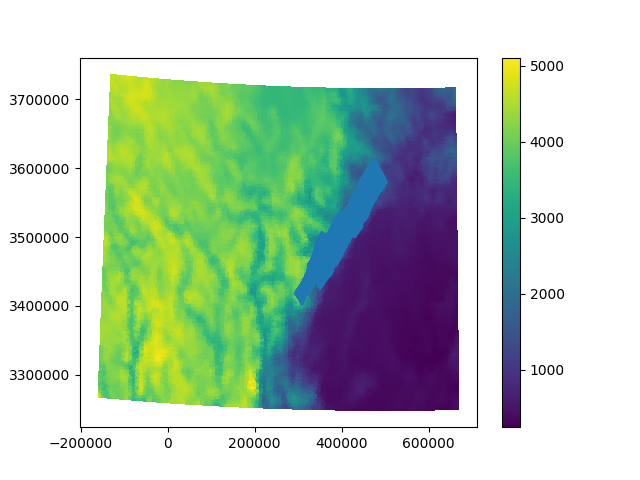

In [14]:
%matplotlib notebook
plt.figure()
plt.tripcolor(proj_m[0][:,0], proj_m[0][:,1], proj_m[1], proj_m[0][:,2])
plt.triplot(fault_m[0][:,0], fault_m[0][:,1], fault_m[1])
plt.colorbar()
plt.show()

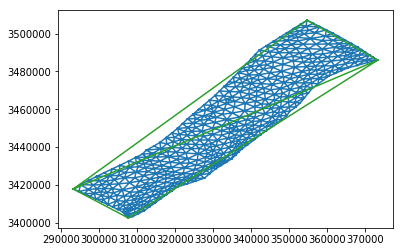

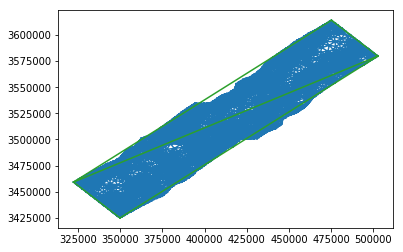

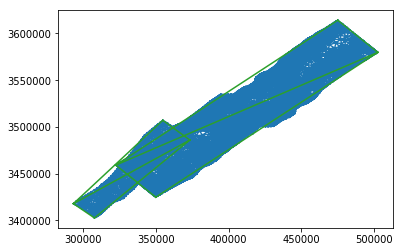

In [16]:
%matplotlib inline
def appx_rect_faults(pts, tris):
    cc = get_connected_components(tris)
    planar_pts = []
    planar_tris = []
    for comp_idx in [0,1]:
        comp_pts = pts[tris[np.where(cc[1] == comp_idx)[0]]].reshape((-1, 3))
        upper_left_idx = np.argmin(comp_pts[:,1])
        bottom_left_idx = np.argmin(comp_pts[:,0])
        bottom_right_idx = np.argmax(comp_pts[:,1])
        upper_right_idx = np.argmax(comp_pts[:,0])


        #need 4 points to define a rectangle, the upper right, bottom right, upper left, bottom left
        corners = np.array([
            comp_pts[bottom_left_idx,:],
            comp_pts[upper_left_idx,:],
            comp_pts[upper_right_idx,:],
            comp_pts[bottom_right_idx,:]
        ])
        planar_pts.append(corners)
        comp_planar_tris = np.array([[0,1,2], [0,2,3]])
        planar_tris.append(4 * comp_idx + comp_planar_tris)

        plt.figure()
        plt.triplot(pts[:,0], pts[:,1], tris[np.where(cc[1] == comp_idx)[0],:])
        plt.triplot(corners[:,0], corners[:,1], comp_planar_tris)
        plt.show()

    planar_pts = np.array(planar_pts).reshape((-1, 3))
    planar_tris = np.array(planar_tris).reshape((-1, 3))
    plt.figure()
    plt.triplot(pts[:,0], pts[:,1], tris)
    plt.triplot(planar_pts[:,0], planar_pts[:,1], planar_tris)
    plt.show()
appx_rect_faults(*fault_m)